In [1]:
# GTM Package including GTM and the plot functions
from gtm import *
# Sample Copulas Package
import pyvinecopulib as pv
import numpy as np
# Other Stuff
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset
import seaborn as sns
import matplotlib.pyplot as plt

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Data

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2452348847.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2452348847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(means,vars).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/57/_f_fv4s97k300zslnyj86dxc0000gn/T/ipykernel_44124/2452348847.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requir

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

In [7]:
# Here you can see that we load the full data, so not batches
# Model is just implemented with dataloaders because that is eeded for huge datasets in bioinformatics
data_iter = iter(dataloader_train)
sample = next(data_iter)
sample.size()

torch.Size([2000, 2])

### 2. Define Model

In [8]:
model = GTM(
    transformation_spline_range=list([[-10], [10]]), 
    decorrelation_spline_range=list([[-10], [10]]), 
    degree_decorrelation=30,
    degree_transformations=15,
    num_decorr_layers=3,
    num_trans_layers=1,
    number_variables=2,
    spline_decorrelation="bspline", #"bspline", #"bernstein",
    spline_transformation="bernstein",
    device="cpu") 

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_layers/transformation_layer.py:61: UserWarning: Warning: Varying Spline Degree for each Dimension is not implemented for Bernstein, only for B-Spline.
  warnings.warn("Warning: Varying Spline Degree for each Dimension is not implemented for Bernstein, only for B-Spline.")
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_layers/transformation_layer.py:66: UserWarning: Bernstein polynomial penalization is not implemented yet. only returns zeros hardcoded in bernstein_prediction.py fct
  warnings.warn("Bernstein polynomial penalization is not implemented yet. only returns zeros hardcoded in bernstein_prediction.py fct")
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bernstein_prediction_vectorized.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour

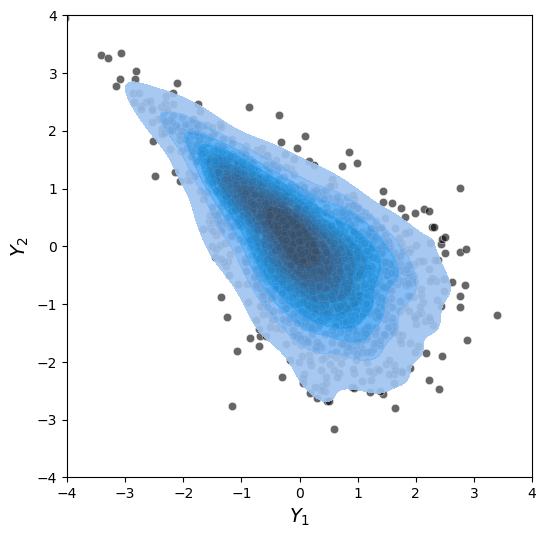

In [9]:
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

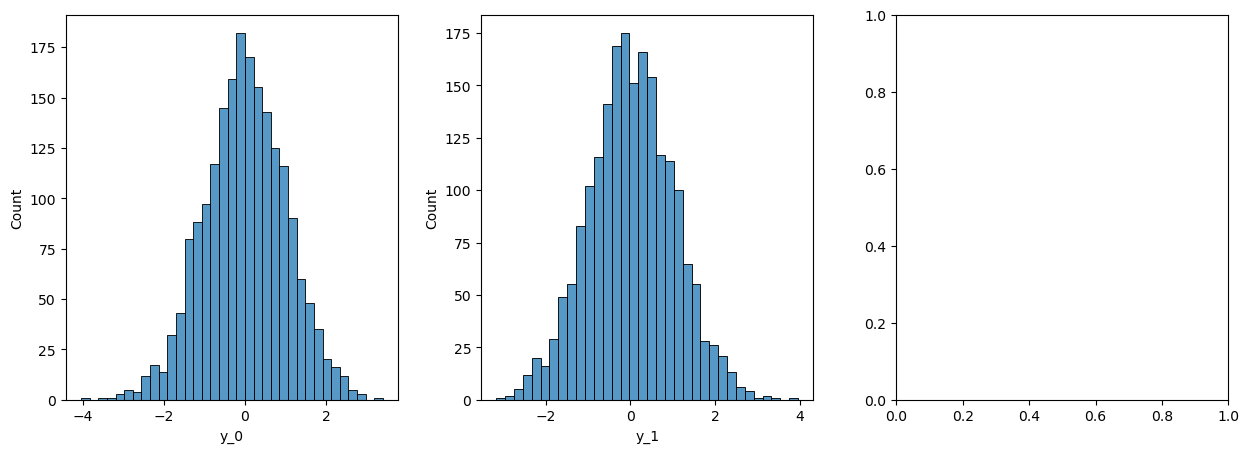

In [10]:
model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

In [11]:
study = model.hyperparameter_tune_penalties( 
                                train_dataloader=dataloader_train, 
                                validate_dataloader=dataloader_validate, 
                                penvalueridge = [0], #["sample"],
                                penfirstridge = ["sample"],
                                pensecondridge = ["sample"],
                                ctm_pensecondridge = [0], #["sample"],
                                lambda_penalty_params = [0], #["sample"],
                                train_covariates=False, 
                                validate_covariates=False, 
                                adaptive_lasso_weights_matrix = False,
                                learning_rate=1, 
                                iterations=1000, 
                                patience=5, 
                                min_delta=1e-7, 
                                optimizer='LBFGS', 
                                lambda_penalty_mode="square", 
                                objective_type="negloglik", 
                                seperate_copula_training=False,
                                max_batches_per_iter=False,
                                tuning_mode="optuna",
                                cross_validation_folds=False,
                                random_state_KFold=42,
                                device=None,
                                pretrained_transformation_layer=False,
                                n_trials=10,
                                temp_folder=".", 
                                study_name=None)
    
penalty_params=torch.FloatTensor([
                            0, #study.best_params["penvalueridge"],
                            study.best_params["penfirstridge"],
                            study.best_params["pensecondridge"],
                            0 #study.best_params["ctm_pensecondridge"]
                              ])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-03 18:25:21,526] A new study created in RDB with name: no-name-f9f33401-a388-4462-9e7d-d4656c0d008b


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 12.987212392028468   pensecondridge_opt: 10.554126658015107   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
 10%|█         | 102/1000 [00:02<00:21, 41.30it/s]
[I 2025-06-03 18:25:24,634] Trial 0 finished with value: -2.472017765045166 and parameters: {'penfirstridge': 12.987212392028468, 'pensecondridge': 10.554126658015107}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 11.231738695812176   pensecondridge_opt: 19.586233346015305   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  2%|▏         | 17/1000 [00:00<00:27, 35.42it/s]
[I 2025-06-03 18:25:25,181] Trial 1 finished with value: -2.532397985458374 and parameters: {'penfirstridge': 11.231738695812176, 'pensecondridge': 19.586233346015305}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 18.068866932650703   pensecondridge_opt: 11.481163376261998   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


 10%|▉         | 97/1000 [00:02<00:21, 41.90it/s]
[I 2025-06-03 18:25:27,532] Trial 2 finished with value: -2.4834718704223633 and parameters: {'penfirstridge': 18.068866932650703, 'pensecondridge': 11.481163376261998}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 18.84261356596209   pensecondridge_opt: 2.5363141315520665   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  4%|▍         | 39/1000 [00:00<00:20, 46.51it/s]
[I 2025-06-03 18:25:28,401] Trial 3 finished with value: -2.498222589492798 and parameters: {'penfirstridge': 18.84261356596209, 'pensecondridge': 2.5363141315520665}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 13.272037686541339   pensecondridge_opt: 4.236422453902508   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  2%|▏         | 23/1000 [00:00<00:27, 34.90it/s]
[I 2025-06-03 18:25:29,091] Trial 4 finished with value: -2.5087924003601074 and parameters: {'penfirstridge': 13.272037686541339, 'pensecondridge': 4.236422453902508}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 23.32678758743272   pensecondridge_opt: 29.248297523555507   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  5%|▌         | 50/1000 [00:01<00:20, 47.02it/s]
[I 2025-06-03 18:25:30,194] Trial 5 finished with value: -2.5102875232696533 and parameters: {'penfirstridge': 23.32678758743272, 'pensecondridge': 29.248297523555507}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.6862278660818166   pensecondridge_opt: 15.111335043377252   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  3%|▎         | 28/1000 [00:00<00:26, 36.92it/s]
[I 2025-06-03 18:25:31,005] Trial 6 finished with value: -2.5012927055358887 and parameters: {'penfirstridge': 2.6862278660818166, 'pensecondridge': 15.111335043377252}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 26.61290763509176   pensecondridge_opt: 15.788610193037208   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  6%|▌         | 62/1000 [00:01<00:22, 42.19it/s]
[I 2025-06-03 18:25:32,507] Trial 7 finished with value: -2.500807046890259 and parameters: {'penfirstridge': 26.61290763509176, 'pensecondridge': 15.788610193037208}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 2.586199196681294   pensecondridge_opt: 2.3606875049517306   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  2%|▏         | 19/1000 [00:00<00:23, 41.30it/s]
[I 2025-06-03 18:25:33,077] Trial 8 finished with value: -2.5067358016967773 and parameters: {'penfirstridge': 2.586199196681294, 'pensecondridge': 2.3606875049517306}. Best is trial 0 with value: -2.472017765045166.


This Trial has the Hyperparameters: penvalueridge_opt: 0   penfirstridge_opt: 29.536566625748424   pensecondridge_opt: 5.404125915777613   ctm_pensecondridge_opt: 0   lambda_penalty_params_opt: 0


  9%|▊         | 87/1000 [00:02<00:21, 42.71it/s]
[I 2025-06-03 18:25:35,148] Trial 9 finished with value: -2.481189012527466 and parameters: {'penfirstridge': 29.536566625748424, 'pensecondridge': 5.404125915777613}. Best is trial 0 with value: -2.472017765045166.


hyperparameter_tuning done


In [11]:

penalty_params = torch.tensor([ 0.0000,  1.7809, 18.6645,  0.0000])
adaptive_lasso_weights_matrix = False
lambda_penalty_params=False

In [12]:
# pretrain the marginal transformations
_ = model.pretrain_tranformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_params=penalty_params)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:328: UserWarning: Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.
  warnings.warn("Optimiser for pretrain_tranformation_layer is always LBFGS. If this is an issue change the code.")
  4%|▍         | 41/1000 [00:00<00:11, 87.08it/s] 


In [13]:
# train the joint model
_ = model.__train__(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_params=penalty_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, lambda_penalty_params=lambda_penalty_params, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:404: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
  2%|▏         | 17/1000 [00:00<00:24, 39.90it/s]


### 4. Compare Fit to Benchmarks

In [14]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [15]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)  # 0 to do mean across dim 0 not globally
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [16]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  0.0569
KLD Gaussian Train Data:  0.1092
KLD Copula   Train Data:  -0.0008
KLD GTM      Test  Data:  0.0556
KLD Gaussian Test  Data:  0.1108
KLD Copula   Test  Data:  0.0014


KLD GTM      Train Data:  0.0113
KLD Gaussian Train Data:  0.1057
KLD Copula   Train Data:  -0.0005
KLD GTM      Test  Data:  0.0117
KLD Gaussian Test  Data:  0.1143
KLD Copula   Test  Data:  0.0009

### 5. Evaluate and Plot GTM Results

In [17]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(2000)

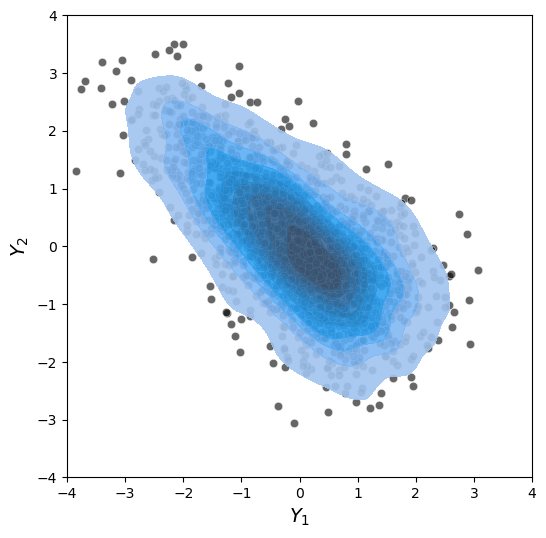

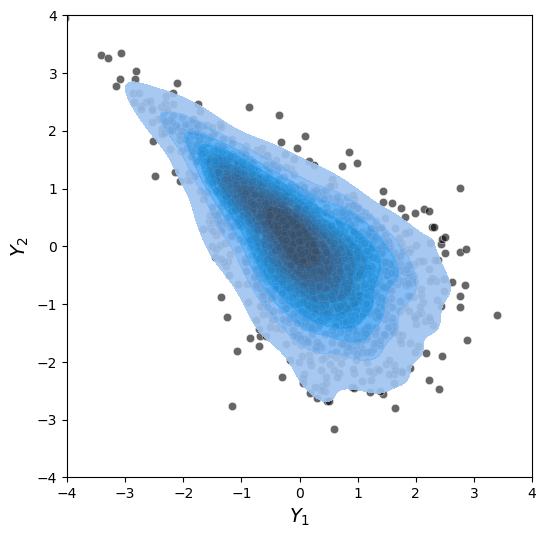

In [18]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [19]:
synthetic_samples = model.sample(2000)
p_matrix = model.compute_precision_matrix(synthetic_samples)

In [20]:
conditional_correlation_matrix_train = model.compute_correlation_matrix(synthetic_samples)
conditional_correlation = conditional_correlation_matrix_train[:,0,1]

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


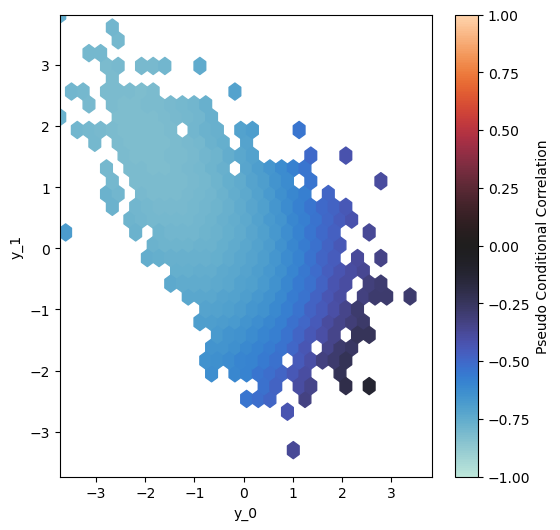

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_plotting="pseudo_conditional_correlation")

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, spline_num],


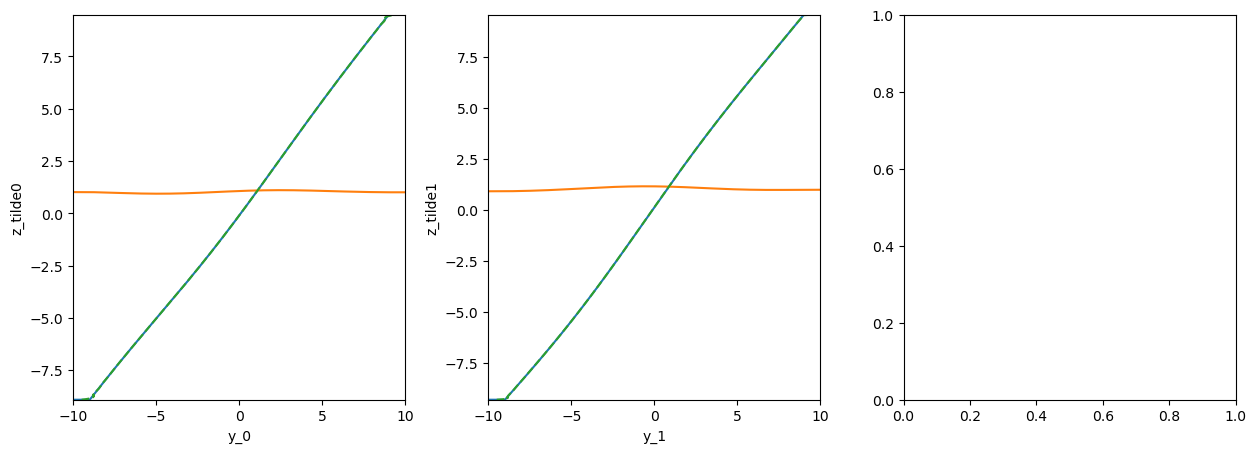

In [29]:
model.plot_splines(layer_type="transformation")

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


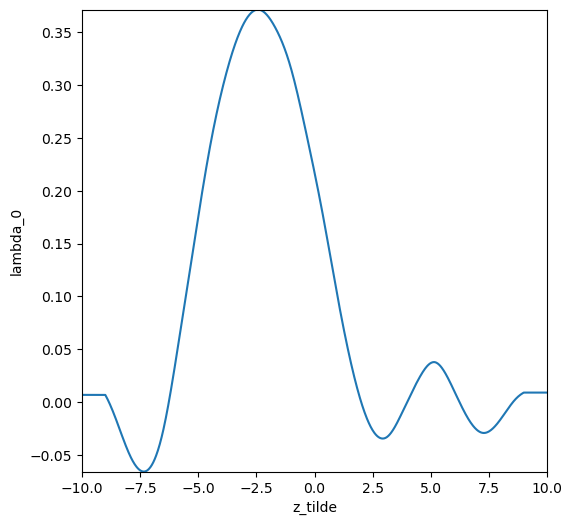

In [30]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


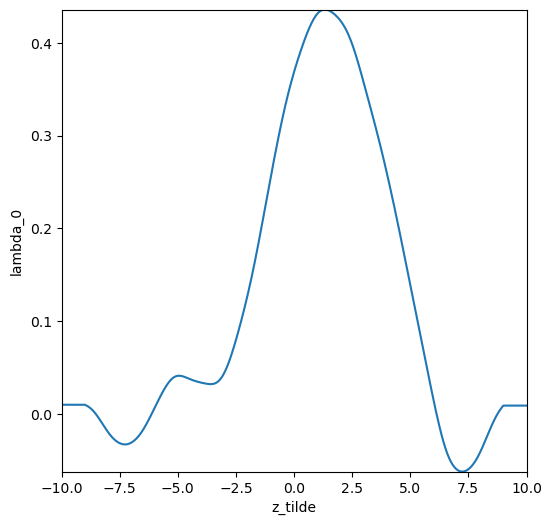

In [31]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_plots_analysis/plot_splines.py:184: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(pd.DataFrame({"y": data_span_vec.detach().numpy()[:, col_indices],


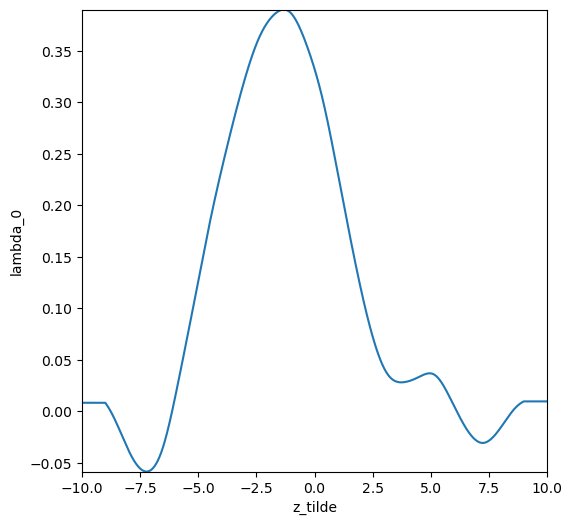

In [32]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)